# Portfolio Optimizer Exploration

This notebook explores the functionality of the `PortfolioOptimizer` class in detail. We'll examine:

1. Basic optimizer initialization and configuration
2. Portfolio metrics calculation
3. Optimization with different objectives
4. Efficient frontier generation and analysis
5. Visualization capabilities
6. Impact of different constraints

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from portfolio_optimization.data import DataCollector, setup_logger as data_logger
from portfolio_optimization.optimization import PortfolioOptimizer, setup_logger as optimizer_logger

# Set up plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
sns.set_palette('husl')

data_logger = data_logger(console_level=None)
optimizer_logger = optimizer_logger(console_level=None)

# Setting pandas display options
pd.options.display.float_format = '{:,.2}'.format

## 1. Basic Optimizer Setup

Let's explore different ways to initialize the optimizer and understand its configuration options.

In [2]:
# Initialize with default parameters
optimizer_default = PortfolioOptimizer()
print("Default optimizer settings:")
print(f"Risk-free rate: {optimizer_default.risk_free_rate:.2%}")
print("Constraints:", optimizer_default.constraints)

# Initialize with custom parameters
custom_constraints = {
    'min_position': 0.05,  # Minimum 5% in any asset
    'max_position': 0.30   # Maximum 30% in any asset
}
optimizer_custom = PortfolioOptimizer()
optimizer_custom.risk_free_rate = 0.03
optimizer_custom.constraints = custom_constraints

print("\nCustom optimizer settings:")
print(f"Risk-free rate: {optimizer_custom.risk_free_rate:.2%}")
print("Constraints:", optimizer_custom.constraints)

Default optimizer settings:
Risk-free rate: 4.00%
Constraints: {'max_position': 0.16666666666666666, 'min_position': 0.0, 'max_sector_exposure': 0.3, 'max_turnover': 0.2}

Custom optimizer settings:
Risk-free rate: 3.00%
Constraints: {'min_position': 0.05, 'max_position': 0.3}


## 2. Data Collection and Preprocessing

Let's get some test data to work with. We'll use a mix of tech stocks and ETFs.

In [3]:
# Initialize data collector
collector = DataCollector()

# Define test assets
tickers = collector.config['universe']['stocks']

# Fetch data
prices = collector.fetch_data(tickers)
returns = prices.pct_change().dropna()

print("Data shape:", returns.shape)
print("\nSummary statistics:")
returns.describe()

Data shape: (2922, 6)

Summary statistics:


,AAPL,MSFT,GOOGL,AMZN,META,NVDA
count,2.9e+03,2.9e+03,2.9e+03,2.9e+03,2.9e+03,2.9e+03
mean,0.001,0.0011,0.00091,0.0011,0.0011,0.0022
std,0.018,0.017,0.017,0.02,0.025,0.028
min,-0.13,-0.15,-0.12,-0.14,-0.26,-0.19
25%,-0.0075,-0.0068,-0.0071,-0.0087,-0.01,-0.011
50%,0.00089,0.00073,0.00078,0.00094,0.001,0.0019
75%,0.01,0.0095,0.0092,0.011,0.013,0.015
max,0.12,0.14,0.16,0.14,0.3,0.3


## 3. Portfolio Metrics Calculation

Let's examine how the optimizer calculates key portfolio metrics.

In [4]:
# Create test weights
equal_weights = np.array([1/len(tickers)] * len(tickers))

# Calculate metrics for equal-weight portfolio
ret, vol, sharpe = optimizer_default.calculate_portfolio_metrics(
    weights=equal_weights,
    returns=returns.values,
    cov_matrix=returns.cov().values
)

print("Equal-weight portfolio metrics:")
print(f"Expected Return (annualized): {ret:.2%}")
print(f"Volatility (annualized): {vol:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")

Equal-weight portfolio metrics:
Expected Return (annualized): 30.93%
Volatility (annualized): 25.78%
Sharpe Ratio: 1.04


In [5]:
def func():
    weights = equal_weights.copy()
    cov_matrix = returns.cov().values
    risk_free_rate = 0.04

    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

    # Handle numerical instability
    if portfolio_vol < 1e-8:
        portfolio_vol = 1e-8
        
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_vol
    return portfolio_return, portfolio_vol, sharpe_ratio
func()

(np.float64(0.3093160844507894),
 np.float64(0.25782501392926316),
 np.float64(1.0445692617112743))

## 4. Portfolio Optimization

Let's explore optimization with different objectives.

In [6]:
# Optimize for different objectives
objectives = ['sharpe', 'volatility', 'return']

optimizer_default.constraints = {
    'min_position': 0.0,   # Allow complete divestment
    'max_position': 0.4    # Allow up to 40% in any asset
}

for objective in objectives:
    print(f"\nOptimizing for {objective}:")
    result = optimizer_default.optimize_portfolio(returns, objective=objective, verbose=False)
    
    print(f"Return: {result['return']:.2%}")
    print(f"Volatility: {result['volatility']:.2%}")
    print(f"Sharpe Ratio: {result['sharpe_ratio']:.2f}")
    print("\nOptimal weights:")
    for asset, weight in result['weights'].items():
        print(f"{asset}: {weight:.2%}")
    print('-*'*30)


Optimizing for sharpe:
Return: 30.93%
Volatility: 23.46%
Sharpe Ratio: 1.15

Optimal weights:
AAPL: 28.63%
MSFT: 31.90%
GOOGL: 30.20%
AMZN: 8.46%
META: 0.80%
NVDA: 0.00%
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Optimizing for volatility:
Return: 30.93%
Volatility: 23.46%
Sharpe Ratio: 1.15

Optimal weights:
AAPL: 28.63%
MSFT: 31.90%
GOOGL: 30.20%
AMZN: 8.45%
META: 0.81%
NVDA: 0.00%
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Optimizing for return:
Return: 30.93%
Volatility: 27.14%
Sharpe Ratio: 0.99

Optimal weights:
AAPL: 12.09%
MSFT: 11.31%
GOOGL: 7.82%
AMZN: 26.09%
META: 28.00%
NVDA: 14.68%
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


### Lets understand the optimizer better



In [7]:
from scipy.optimize import minimize

def func(objective):
    cov_matrix = returns.cov()  # Remove .values since cov() already returns numpy array
    n_assets = len(returns.columns)
    print(f"Input data: {n_assets} assets, {len(returns)} time periods")

    min_max_position = 1.0 / n_assets
    print(f"Possible min max position: {min_max_position:.2%}")
    print(f"Position constraints: min={optimizer_default.constraints['min_position']:.2%}, max={optimizer_default.constraints['max_position']:.2%}")
    max_position = max(min_max_position, optimizer_default.constraints['max_position'])
    print(f"Final Max position: {max_position:.2%}")

    optimization_weights = equal_weights
    print(f"Initial weights: {optimization_weights}")
    optimization_weights = np.clip(
        optimization_weights,
        optimizer_default.constraints['min_position'],
        max_position
    )
    print(f"Clipped weights: {optimization_weights}")
    optimization_weights = optimization_weights / np.sum(optimization_weights)
    print(f"Normalized weights: {optimization_weights}")

    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # Weights sum to 1
    ]

    bounds = tuple(
        (max(0.0, optimizer_default.constraints['min_position']), min(1.0, max_position))
        for _ in range(n_assets)
    )
    print(f"Bounds: {bounds}")

    best_result = None
    best_metric = float('inf')

    methods = ['SLSQP']
    for method in methods:
        for attempt in range(3):
            result = minimize(
                fun=optimizer_default.objective_function,
                x0=optimization_weights,
                args=(returns, cov_matrix, objective),  # Remove .values since already numpy arrays
                method=method,
                bounds=bounds,
                constraints=constraints,
                options={
                    'ftol': 1e-8,
                    'maxiter': 1000,
                    'disp': False
                }
            )

        if result.success:
            metric = optimizer_default.objective_function(
                result.x, returns, cov_matrix, objective  # Remove .values since already numpy arrays
            )
            if metric < best_metric:
                best_result = result
                best_metric = metric
                best_weights = result.x
        else:
            print(f"Optimization attempt failed: {result.message}")

        # Try new random weights for next iteration
        optimization_weights = np.random.dirichlet(np.ones(n_assets))
        optimization_weights = np.clip(
            optimization_weights,
            optimizer_default.constraints['min_position'],
            max_position
        )
        optimization_weights = optimization_weights / np.sum(optimization_weights)

    # Calculate portfolio metrics
    portfolio_return, portfolio_vol, sharpe_ratio = optimizer_default.calculate_portfolio_metrics(
        best_weights, returns.values, cov_matrix.values
    )

    print(f"Best result: {best_result}")
    print(f"Best metric: {best_metric}")
    print(f"Best weights: {best_weights}")
    print(f"Portfolio return: {portfolio_return:.2%}")
    print(f"Portfolio volatility: {portfolio_vol:.2%}")
    print(f"Portfolio sharpe ratio: {sharpe_ratio:.2f}")



    return best_result, best_metric, best_weights, portfolio_return, portfolio_vol, sharpe_ratio
func('sharpe');
print('-*'*30)
func('volatility');
print('-*'*30)
func('return');


Input data: 6 assets, 2922 time periods
Possible min max position: 16.67%
Position constraints: min=0.00%, max=40.00%
Final Max position: 40.00%
Initial weights: [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Clipped weights: [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Normalized weights: [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Bounds: ((0.0, 0.4), (0.0, 0.4), (0.0, 0.4), (0.0, 0.4), (0.0, 0.4), (0.0, 0.4))
Best result:  message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.148193121859534
       x: [ 2.863e-01  3.189e-01  3.022e-01  8.460e-02  8.016e-03
            0.000e+00]
     nit: 6
     jac: [-1.706e-01 -1.706e-01 -1.705e-01 -1.705e-01 -1.705e-01
            6.240e-02]
    nfev: 42
    njev: 6
Best metric: -1.148193121859534
Best weights: [0.28631224 0.31891828 0.30215512 0.08459849 0.00801587 0.        ]
Portfolio return: 30.93%
Portfolio volatility: 23.46%
Portfolio sharpe 

## 5. Efficient Frontier Analysis

Let's generate and analyze the efficient frontier.

In [8]:
# Generate efficient frontier
n_points = 100
target_returns = np.linspace(0.25, 0.35, n_points)

optimizer_custom.constraints = {
    'min_position': 0.0,   # Allow complete divestment
    'max_position': 1.0   # Allow up to 40% in any asset
}

ef = optimizer_custom.generate_efficient_frontier(returns, n_points=n_points, verbose=False)

In [9]:
ef

,return,volatility,sharpe_ratio,weights,return_diff,volatility_diff
0,0.29,0.24,1.1,"{'AAPL': 0.24692573876469354, 'MSFT': 0.335943...",NaN,NaN
1,0.29,0.24,1.1,"{'AAPL': 0.24660951162259867, 'MSFT': 0.335818...",0.00034,0.00012
2,0.29,0.24,1.1,"{'AAPL': 0.24655881664928947, 'MSFT': 0.335798...",5.4e-05,2e-05
3,0.29,0.24,1.1,"{'AAPL': 0.2461827415985053, 'MSFT': 0.3356505...",0.0004,0.00015
4,0.29,0.24,1.1,"{'AAPL': 0.24615594838347998, 'MSFT': 0.335639...",2.9e-05,1e-05
...,...,...,...,...,...,...
95,0.32,0.26,1.1,"{'AAPL': 0.2195782566761266, 'MSFT': 0.3251703...",0.00021,0.00011
96,0.32,0.26,1.1,"{'AAPL': 0.2191491549242058, 'MSFT': 0.3250012...",0.00046,0.00023
97,0.32,0.26,1.1,"{'AAPL': 0.2188894398986635, 'MSFT': 0.3248989...",0.00028,0.00014
98,0.32,0.26,1.1,"{'AAPL': 0.21863333547155658, 'MSFT': 0.324798...",0.00027,0.00014


<Figure size 1200x600 with 0 Axes>

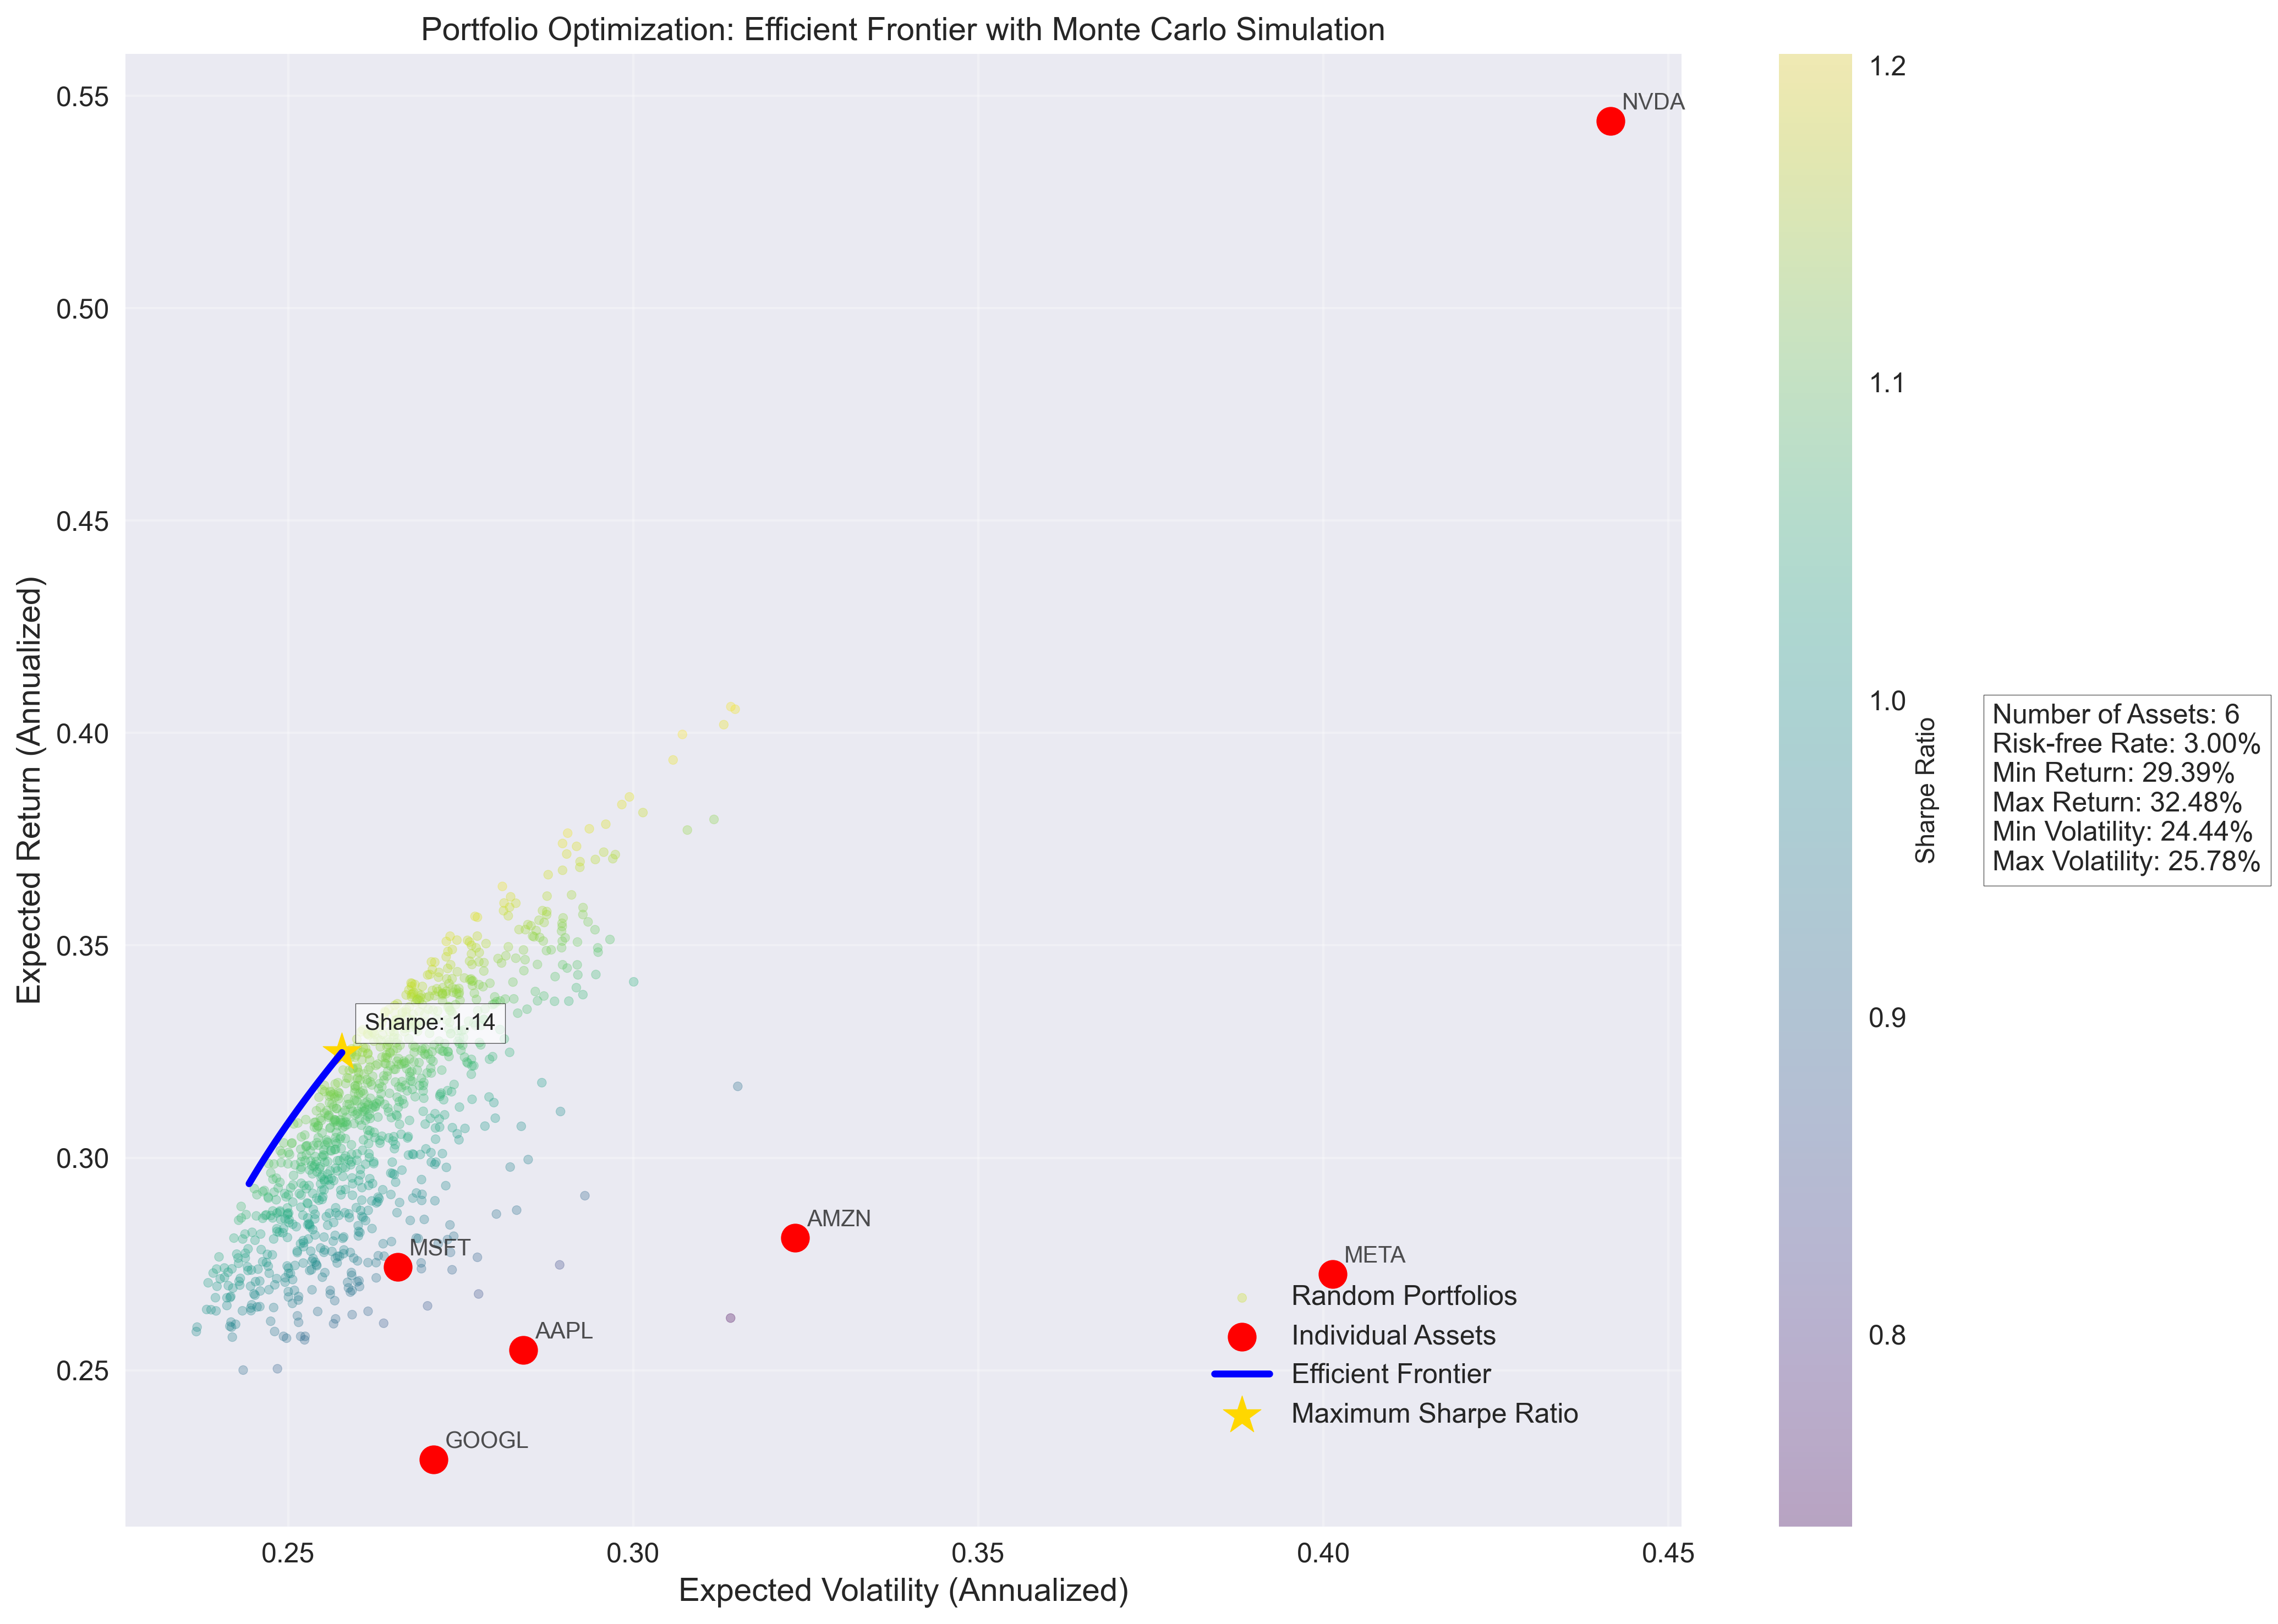

In [10]:
# Plot efficient frontier
optimizer_custom.plot_efficient_frontier(ef, show_sharpe=True, show_assets=True, returns=returns);

## 6. Impact of Constraints

Let's analyze how different constraints affect the optimal portfolio.

In [11]:
# Test different constraint sets
constraint_sets = [
    {'min_position': 0.0, 'max_position': 1.0},  # No constraints
    {'min_position': 0.05, 'max_position': 0.3}, # Moderate constraints
    {'min_position': 0.1, 'max_position': 0.2}   # Tight constraints
]

for constraints in constraint_sets:
    print(f"\nOptimizing with constraints: {constraints}")
    opt = PortfolioOptimizer()
    opt.constraints = constraints
    result = opt.optimize_portfolio(returns, objective='sharpe')
    
    print(f"Return: {result['return']:.2%}")
    print(f"Volatility: {result['volatility']:.2%}")
    print(f"Sharpe Ratio: {result['sharpe_ratio']:.2f}")
    print("\nOptimal weights:")
    for asset, weight in result['weights'].items():
        print(f"{asset}: {weight:.2%}")
    print('-*'*40)


Optimizing with constraints: {'min_position': 0.0, 'max_position': 1.0}
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1481931218588022
            Iterations: 6
            Function evaluations: 42
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1481931294790497
            Iterations: 7
            Function evaluations: 50
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1481931184416927
            Iterations: 7
            Function evaluations: 61
            Gradient evaluations: 7
Return: 30.93%
Volatility: 23.46%
Sharpe Ratio: 1.15

Optimal weights:
AAPL: 28.63%
MSFT: 31.90%
GOOGL: 30.20%
AMZN: 8.46%
META: 0.80%
NVDA: 0.00%
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Optimizing with constraints: {'min_position': 0.05, 'max_position': 0.3

## 7. Portfolio Weight Analysis

Let's visualize how portfolio weights change along the efficient frontier.

<Figure size 1200x600 with 0 Axes>

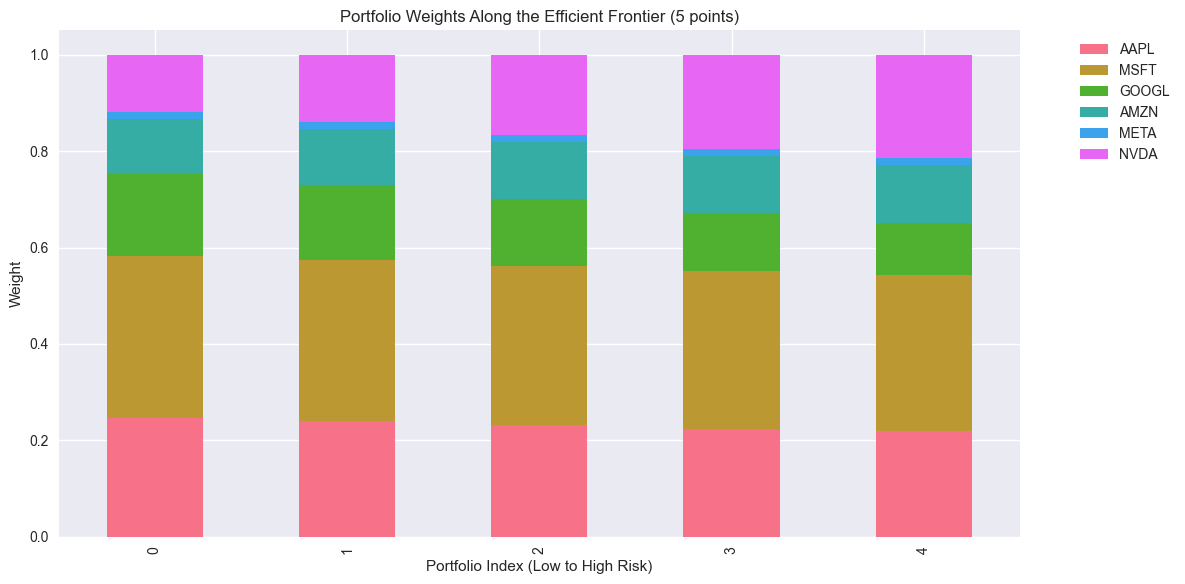

In [12]:
ef = optimizer_custom.generate_efficient_frontier(returns, n_points=5, verbose=False)
# Plot weights for selected portfolios along the efficient frontier
optimizer_custom.plot_portfolio_weights(ef, n_points=5);